### Multi step model (simple encoder-decoder)

In this notebook, we demonstrate how to:
- prepare time series data for training a RNN forecasting model
- get data in the required shape for the keras API
- implement a RNN model in keras to predict the next 3 steps ahead (time *t+1* to *t+3*) in the time series. This model uses a simple encoder decoder approach in which the final hidden state of the encoder is replicated across each time step of the decoder. 
- enable early stopping to reduce the likelihood of model overfitting
- evaluate the model on a test dataset

The data in this example is taken from the GEFCom2014 forecasting competition<sup>1</sup>. It consists of 3 years of hourly electricity load and temperature values between 2012 and 2014. The task is to forecast future values of electricity load.

<sup>1</sup>Tao Hong, Pierre Pinson, Shu Fan, Hamidreza Zareipour, Alberto Troccoli and Rob J. Hyndman, "Probabilistic energy forecasting: Global Energy Forecasting Competition 2014 and beyond", International Journal of Forecasting, vol.32, no.3, pp 896-913, July-September, 2016.

In [63]:
import os
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
from collections import UserDict
from IPython.display import Image
%matplotlib inline

from common.utils import load_data, mape, TimeSeriesTensor, create_evaluation_df

pd.options.display.float_format = '{:,.20f}'.format
np.set_printoptions(precision=20)
warnings.filterwarnings("ignore")

In [64]:
df = pd.read_csv("Cleaned1.csv" , parse_dates = True)
a = pd.to_datetime(df['Epoch_Time_of_Clock'])
print(type(a[0]))
df = df.drop(['Unnamed: 0', 'Unnamed: 0.1' ,'sqrt_A' ,'e' ,'PRN','SV_Clock_Bias', 'SV_Clock_Drift', 'SV_Clock_Drift_Rate', 'IODE', 'Cis',
       'OMEGA', 'i0', 'Cuc','Cus','Toe', 'OMEGA_dot', 'omega',
       'Crc', 'Cic', 'M0', 'I_dot', 'Del_n', 'Codes', 'GPS_week',
       'L2_P_Data_flag', 'SV_accuracy', 'SV_health', 'Tgd', 'IODC', 'T_Tx',
       'Fit_Interval' ,'Epoch_Time_of_Clock' ],axis =1 )
df.head()
#df = df.set_index(['Epoch_Time_of_Clock'])
df = df.set_index(a)
df.head()

<class 'pandas._libs.tslibs.timestamps.Timestamp'>


,Crs
Epoch_Time_of_Clock,
2017-11-01 14:00:00,20.71875000000000000000
2017-11-01 16:00:00,16.81250000000000000000
2017-11-01 18:00:00,13.84375000000000000000
2017-11-01 20:00:00,12.28125000000000000000
2017-11-01 22:00:00,23.03125000000000000000


In [66]:
sat_var  = 1
var_name = 'Crs'

In [67]:

df = df.iloc[5 : , :]

In [68]:

df.head(7)

,Crs
Epoch_Time_of_Clock,
2017-11-02 12:00:00,40.03125000000000000000
2017-11-02 14:00:00,46.56250000000000000000
2017-11-02 16:00:00,43.84375000000000000000
2017-11-02 18:00:00,41.75000000000000000000
2017-11-02 20:00:00,38.53125000000000000000
2017-11-02 22:00:00,47.28125000000000000000
2017-11-03 12:00:00,53.62500000000000000000


# Enter number of entries per day

In [69]:
entry = 6
print(df.shape[0])
no_of_entries = df.shape[0]//entry
valid = (no_of_entries * 70)//100
test = (no_of_entries * 85)//100
indexes = df.index
#print(valid , test , indexes)
valid_start_dt = indexes[int(valid)*int(entry)] 
test_start_dt = indexes [int(test)*int(entry)] 
test_start_dt = str(test_start_dt)
valid_start_dt = str(valid_start_dt)
print(test_start_dt,valid_start_dt)
print(type(test_start_dt))

168
2017-11-25 12:00:00 2017-11-21 12:00:00
<class 'str'>



Load data into Pandas dataframe

# enter lag and no. of outputs

In [70]:
"""total = len(df)
t = total*70/100
t = round(t)
indexes = df.index
valid_start_dt = str(indexes[t])
t = total*85/100
t = round(t)
test_start_dt = str(indexes[t])
print(valid_start_dt , test_start_dt)
"""
T = 6
HORIZON = 6

Create training set containing only the model features

In [71]:
train = df.copy()[df.index < valid_start_dt][[var_name ]]
train.head()

,Crs
Epoch_Time_of_Clock,
2017-11-02 12:00:00,40.03125000000000000000
2017-11-02 14:00:00,46.56250000000000000000
2017-11-02 16:00:00,43.84375000000000000000
2017-11-02 18:00:00,41.75000000000000000000
2017-11-02 20:00:00,38.53125000000000000000


In [72]:
train.tail(6)

,Crs
Epoch_Time_of_Clock,
2017-11-20 12:00:00,-20.40625000000000000000
2017-11-20 14:00:00,-14.06250000000000000000
2017-11-20 16:00:00,-13.00000000000000000000
2017-11-20 18:00:00,-23.15625000000000000000
2017-11-20 20:00:00,-30.34375000000000000000
2017-11-20 22:00:00,-34.81250000000000000000


Scale data to be in range (0, 1). This transformation should be calibrated on the training set only. This is to prevent information from the validation or test sets leaking into the training data.

# Enter variable to be predicted

In [73]:
from sklearn.preprocessing import StandardScaler



y_scalar = StandardScaler()
y_scalar.fit(train[[var_name]])


X_scaler = StandardScaler()
train[[var_name]] = X_scaler.fit_transform(train)

Use the TimeSeriesTensor convenience class to:
1. Shift the values of the time series to create a Pandas dataframe containing all the data for a single training example
2. Discard any samples with missing values
3. Transform this Pandas dataframe into a numpy array of shape (samples, time steps, features) for input into Keras

The class takes the following parameters:

- **dataset**: original time series
- **H**: the forecast horizon
- **tensor_structure**: a dictionary discribing the tensor structure in the form { 'tensor_name' : (range(max_backward_shift, max_forward_shift), [feature, feature, ...] ) }
- **freq**: time series frequency
- **drop_incomplete**: (Boolean) whether to drop incomplete samples

In [74]:
tensor_structure = {'X':(range(-T+1, 1), [var_name])}
train_inputs = TimeSeriesTensor(train, var_name, HORIZON, {'X':(range(-T+1, 1), [var_name])} ,freq = None)

In [75]:
train_inputs.dataframe

tensor                               target                          \
feature                                   y                           
time step                               t+1                     t+2   
Epoch_Time_of_Clock                                                   
2017-11-02 22:00:00  1.25648673649307562883  1.35104152049560211069   
2017-11-03 12:00:00  1.35104152049560211069  1.30246885748060559074   
2017-11-03 14:00:00  1.30246885748060559074  1.30635467052180542780   
2017-11-03 16:00:00  1.30635467052180542780  1.24936274591754292729   
2017-11-03 18:00:00  1.24936274591754292729  1.36658477266040101483   
2017-11-03 20:00:00  1.36658477266040101483  1.19884717638194659983   
2017-11-03 22:00:00  1.19884717638194659983  1.20856170898494585941   
2017-11-04 12:00:00  1.20856170898494585941  1.12760727062661869624   
2017-11-04 14:00:00  1.12760727062661869624  1.15156978438068358095   
2017-11-04 16:00:00  1.15156978438068358095  1.14509342931201740790   
2017-11-04 18:00:00  1.14509342931201740790  1.21439042854674550398   
2017-11-04 20:00:00  1.21439042854674550398  0.78954153604224375229   
2017-11-04 22:00:00  0.78954153604224375229  0.71247291072511609311   
2017-11-05 12:00:00  0.71247291072511609311  0.56027856661146069328   
2017-11-05 14:00:00  0.56027856661146069328  0.53243023981619608254   
2017-11-05 16:00:00  0.53243023981619608254  0.58359344485865893848   
2017-11-05 18:00:00  0.58359344485865893848  0.65353807960025378510   
2017-11-05 20:00:00  0.65353807960025378510  0.13089622555889260380   
2017-11-05 22:00:00  0.13089622555889260380  0.00525493722676860855   
2017-11-06 12:00:00  0.00525493722676860855 -0.22724620973834747106   
2017-11-06 14:00:00 -0.22724620973834747106 -0.36907838574213697180   
2017-11-06 16:00:00 -0.36907838574213697180 -0.29395266694560917564   
2017-11-06 18:00:00 -0.29395266694560917564 -0.17414009817528475210   
2017-11-06 20:00:00 -0.17414009817528475210 -0.59445554213172024927   
2017-11-06 22:00:00 -0.59445554213172024927 -0.71167756887457822579   
2017-11-07 12:00:00 -0.71167756887457822579 -0.99534192088215711625   
2017-11-07 14:00:00 -0.99534192088215711625 -1.24921503957387169947   
2017-11-07 16:00:00 -1.24921503957387169947 -1.19934710554514212255   
2017-11-07 18:00:00 -1.19934710554514212255 -1.01736152811562230447   
2017-11-07 20:00:00 -1.01736152811562230447 -1.19222311496960919897   
...                                     ...                     ...   
2017-11-15 12:00:00  0.83940947007097332921  0.90028720771643544474   
2017-11-15 14:00:00  0.90028720771643544474  0.86984833889370438698   
2017-11-15 16:00:00  0.86984833889370438698  0.85171454470143903581   
2017-11-15 18:00:00  0.85171454470143903581  0.88603922656536981961   
2017-11-15 20:00:00  0.88603922656536981961  1.02916667358289259937   
2017-11-15 22:00:00  1.02916667358289259937  1.05053864530949092604   
2017-11-16 12:00:00  1.05053864530949092604  1.06737716848802310921   
2017-11-16 14:00:00  1.06737716848802310921  0.92813553451170005548   
2017-11-16 16:00:00  0.92813553451170005548  0.87761996497610383905   
2017-11-16 18:00:00  0.87761996497610383905  0.92424972147050032945   
2017-11-16 20:00:00  0.92424972147050032945  0.99548962722582845508   
2017-11-16 22:00:00  0.99548962722582845508  1.03564302865155877242   
2017-11-17 12:00:00  1.03564302865155877242  1.01427105692496044576   
2017-11-17 14:00:00  1.01427105692496044576  0.78824626502851047327   
2017-11-17 16:00:00  0.78824626502851047327  0.69757729406718382847   
2017-11-17 18:00:00  0.69757729406718382847  0.73708305998604761733   
2017-11-17 20:00:00  0.73708305998604761733  0.72607325636931507873   
2017-11-17 22:00:00  0.72607325636931507873  0.79796079763150973285   
2017-11-18 12:00:00  0.79796079763150973285  0.76234084475384567003   
2017-11-18 14:00:00  0.76234084475384567003  0.49292447389733240470   
2017-11-18 16:00:00  0.49292447389733240470  0.36663555005834175260   
2017-11-18 18:00:00  0.3

In [76]:
train_inputs['target'].shape

(103, 6)

Construct validation set (keeping T hours from the training set in order to construct initial features)

In [77]:
look_back_dt = dt.datetime.strptime(valid_start_dt, '%Y-%m-%d %H:%M:%S') - dt.timedelta(hours=T-1)
valid = df.copy()[(df.index >=look_back_dt) & (df.index < test_start_dt)][[var_name]]
valid[[var_name]] = X_scaler.transform(valid)
valid_inputs = TimeSeriesTensor(valid, var_name, HORIZON, tensor_structure,freq = None)
valid_inputs.dataframe.head()

tensor                               target                          \
feature                                   y                           
time step                               t+1                     t+2   
Epoch_Time_of_Clock                                                   
2017-11-21 22:00:00 -1.29649243157513471836 -1.18250858236660993938   
2017-11-22 12:00:00 -1.18250858236660993938 -1.05039093896581969823   
2017-11-22 14:00:00 -1.05039093896581969823 -1.09378251792588310209   
2017-11-22 16:00:00 -1.09378251792588310209 -1.18250858236660993938   
2017-11-22 18:00:00 -1.18250858236660993938 -1.33535056198713175668   

tensor                                                               \
feature                                                               
time step                               t+3                     t+4   
Epoch_Time_of_Clock                                                   
2017-11-21 22:00:00 -1.05039093896581969823 -1.09378251792588310209   
2017-11-22 12:00:00 -1.09378251792588310209 -1.18250858236660993938   
2017-11-22 14:00:00 -1.18250858236660993938 -1.33535056198713175668   
2017-11-22 16:00:00 -1.33535056198713175668 -1.59634767125437915247   
2017-11-22 18:00:00 -1.59634767125437915247 -1.52510776549905102684   

tensor                                                               \
feature                                                               
time step                               t+5                     t+6   
Epoch_Time_of_Clock                                                   
2017-11-21 22:00:00 -1.18250858236660993938 -1.33535056198713175668   
2017-11-22 12:00:00 -1.33535056198713175668 -1.59634767125437915247   
2017-11-22 14:00:00 -1.59634767125437915247 -1.52510776549905102684   
2017-11-22 16:00:00 -1.52510776549905102684 -1.36125598226179644890   
2017-11-22 18:00:00 -1.36125598226179644890 -1.32887420691846558363   

tensor                                    X                          \
feature                                 Crs                           
time step                               t-5                     t-4   
Epoch_Time_of_Clock                                                   
2017-11-21 22:00:00 -0.83149013764490264933 -0.69678195221664596115   
2017-11-22 12:00:00 -0.69678195221664596115 -0.61777042037891849446   
2017-11-22 14:00:00 -0.61777042037891849446 -0.74859279276597545660   
2017-11-22 16:00:00 -0.74859279276597545660 -0.87811989413929925075   
2017-11-22 18:00:00 -0.87811989413929925075 -1.01218044406068918839   

tensor                                                               \
feature                                                               
time step                               t-3                     t-2   
Epoch_Time_of_Clock                                                   
2017-11-21 22:00:00 -0.61777042037891849446 -0.74859279276597545660   
2017-11-22 12:00:00 -0.74859279276597545660 -0.87811989413929925075   
2017-11-22 14:00:00 -0.87811989413929925075 -1.01218044406068918839   
2017-11-22 16:00:00 -1.01218044406068918839 -1.29649243157513471836   
2017-11-22 18:00:00 -1.29649243157513471836 -1.18250858236660993938   

tensor                                                               
feature                                                              
time step                               t-1                       t  
Epoch_Time_of_Clock                                                  
2017-11-21 22:00:00 -0.87811989413929925075 -1.01218044406068918839  
2017-11-22 12:00:00 -1.01218044406068918839 -1.29649243157513471836  
2017-11-22 14:00:00 -1.29649243157513471836 -1.18250858236660993938  
2017-11-22 16:00:00 -1.18250858236660993938 -1.05039093896581969823  
2017-11-22 18:00:00 -1.05039093896581969823 -1.09378251792588310209

## Implement the RNN

We will implement a RNN forecasting model with the following structure:

In [78]:
#Image('./images/simple_encoder_decoder.png')

In [79]:
from keras.models import Model, Sequential
from keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, Flatten
from keras.callbacks import EarlyStopping ,ModelCheckpoint

In [80]:
LATENT_DIM = 64
BATCH_SIZE = 8
EPOCHS = 10

In [81]:
model = Sequential()
model.add(LSTM(LATENT_DIM, input_shape=(T,1 )))
model.add(RepeatVector(HORIZON))
model.add(LSTM(LATENT_DIM, return_sequences=True))
model.add(TimeDistributed(Dense(1)))
model.add(Flatten())

In [82]:
model.compile(optimizer='RMSprop', loss='mse')

In [83]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 64)                16896     
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 6, 64)             0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 6, 64)             33024     
_________________________________________________________________
time_distributed_2 (TimeDist (None, 6, 1)              65        
_________________________________________________________________
flatten_2 (Flatten)          (None, 6)                 0         
Total params: 49,985
Trainable params: 49,985
Non-trainable params: 0
_________________________________________________________________


In [84]:
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=500)

In [85]:
best_val = ModelCheckpoint(str(sat_var) +'_' +  var_name + '_{epoch:02d}.h5', save_best_only=True, mode='min', period=1)

In [86]:
history = model.fit(train_inputs['X'],
          train_inputs['target'],
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          validation_data=(valid_inputs['X'], valid_inputs['target']),
          callbacks=[earlystop ,best_val],
          verbose=1 , shuffle = False)

Train on 103 samples, validate on 13 samples
Epoch 1/10
103/103 [==============================] - 2s 16ms/step - loss: 0.6924 - val_loss: 0.7645
Epoch 2/10
103/103 [==============================] - 0s 1ms/step - loss: 0.4133 - val_loss: 0.6024
Epoch 3/10
103/103 [==============================] - 0s 1ms/step - loss: 0.3779 - val_loss: 0.5513
Epoch 4/10
103/103 [==============================] - 0s 3ms/step - loss: 0.3586 - val_loss: 0.5116
Epoch 5/10
103/103 [==============================] - 0s 2ms/step - loss: 0.3417 - val_loss: 0.4766
Epoch 6/10
103/103 [==============================] - 0s 1ms/step - loss: 0.3259 - val_loss: 0.4451
Epoch 7/10
103/103 [==============================] - 0s 2ms/step - loss: 0.3109 - val_loss: 0.4174
Epoch 8/10
103/103 [==============================] - 0s 1ms/step - loss: 0.2965 - val_loss: 0.3933
Epoch 9/10
103/103 [==============================] - 0s 1ms/step - loss: 0.2827 - val_loss: 0.3729
Epoch 10/10
103/103 [==============================] -

In [87]:
best_epoch = np.argmin(np.array(history.history['val_loss']))+1
model.load_weights(str(sat_var) +'_' +  var_name + '_{:02d}.h5'.format(best_epoch))

## Evaluate the model

In [88]:
look_back_dt = dt.datetime.strptime(test_start_dt, '%Y-%m-%d %H:%M:%S') - dt.timedelta(hours=T-1)
test = df.copy()[test_start_dt:][[var_name]]
test[[var_name]] = X_scaler.transform(test)
test_inputs = TimeSeriesTensor(test, var_name, HORIZON, tensor_structure,freq =None)
test_inputs.dataframe.head()

tensor                               target                          \
feature                                   y                           
time step                               t+1                     t+2   
Epoch_Time_of_Clock                                                   
2017-11-25 22:00:00 -1.16955587222927759328 -1.24597686203953861295   
2017-11-26 12:00:00 -1.24597686203953861295 -1.18380385338034321840   
2017-11-26 14:00:00 -1.18380385338034321840 -1.11450685414561490028   
2017-11-26 16:00:00 -1.11450685414561490028 -0.95389324844269363091   
2017-11-26 18:00:00 -0.95389324844269363091 -0.90596822093456375047   

tensor                                                               \
feature                                                               
time step                               t+3                     t+4   
Epoch_Time_of_Clock                                                   
2017-11-25 22:00:00 -1.18380385338034321840 -1.11450685414561490028   
2017-11-26 12:00:00 -1.11450685414561490028 -0.95389324844269363091   
2017-11-26 14:00:00 -0.95389324844269363091 -0.90596822093456375047   
2017-11-26 16:00:00 -0.90596822093456375047 -0.63266603703685075910   
2017-11-26 18:00:00 -0.63266603703685075910 -0.72398264350504393239   

tensor                                                               \
feature                                                               
time step                               t+5                     t+6   
Epoch_Time_of_Clock                                                   
2017-11-25 22:00:00 -0.95389324844269363091 -0.90596822093456375047   
2017-11-26 12:00:00 -0.90596822093456375047 -0.63266603703685075910   
2017-11-26 14:00:00 -0.63266603703685075910 -0.72398264350504393239   
2017-11-26 16:00:00 -0.72398264350504393239 -0.72916372755997693744   
2017-11-26 18:00:00 -0.72916372755997693744 -0.71167756887457822579   

tensor                                    X                          \
feature                                 Crs                           
time step                               t-5                     t-4   
Epoch_Time_of_Clock                                                   
2017-11-25 22:00:00 -1.53611756911578356544 -1.57368042851404732474   
2017-11-26 12:00:00 -1.57368042851404732474 -1.44868677568879000717   
2017-11-26 14:00:00 -1.44868677568879000717 -1.35542726269999702637   
2017-11-26 16:00:00 -1.35542726269999702637 -1.25374848812193806502   
2017-11-26 18:00:00 -1.25374848812193806502 -1.28030154390346928572   

tensor                                                               \
feature                                                               
time step                               t-3                     t-2   
Epoch_Time_of_Clock                                                   
2017-11-25 22:00:00 -1.44868677568879000717 -1.35542726269999702637   
2017-11-26 12:00:00 -1.35542726269999702637 -1.25374848812193806502   
2017-11-26 14:00:00 -1.25374848812193806502 -1.28030154390346928572   
2017-11-26 16:00:00 -1.28030154390346928572 -1.16955587222927759328   
2017-11-26 18:00:00 -1.16955587222927759328 -1.24597686203953861295   

tensor                                                               
feature                                                              
time step                               t-1                       t  
Epoch_Time_of_Clock                                                  
2017-11-25 22:00:00 -1.25374848812193806502 -1.28030154390346928572  
2017-11-26 12:00:00 -1.28030154390346928572 -1.16955587222927759328  
2017-11-26 14:00:00 -1.16955587222927759328 -1.24597686203953861295  
2017-11-26 16:00:00 -1.24597686203953861295 -1.18380385338034321840  
2017-11-26 18:00:00 -1.18380385338034321840 -1.11450685414561490028

In [31]:
test_inputs.dataframe.head(50)

tensor                               target                          \
feature                                   y                           
time step                               t+1                     t+2   
Epoch_Time_of_Clock                                                   
2017-11-25 20:00:00 -1.23691152716682006840 -1.12630637496754237858   
2017-11-25 22:00:00 -1.12630637496754237858 -1.20263039812259964201   
2017-11-26 12:00:00 -1.20263039812259964201 -1.14053627758967168759   
2017-11-26 14:00:00 -1.14053627758967168759 -1.07132720574567930072   
2017-11-26 16:00:00 -1.07132720574567930072 -0.91091739436894891835   
2017-11-26 18:00:00 -0.91091739436894891835 -0.86305317645815027294   
2017-11-26 20:00:00 -0.86305317645815027294 -0.59009777161548826463   
2017-11-26 22:00:00 -0.59009777161548826463 -0.68129851114822603808   
2017-11-27 12:00:00 -0.68129851114822603808 -0.68647302119263675646   
2017-11-27 14:00:00 -0.68647302119263675646 -0.66900904979275077622   
2017-11-27 16:00:00 -0.66900904979275077622 -0.47108404059404318520   
2017-11-27 18:00:00 -0.47108404059404318520 -0.36500658468362473519   
2017-11-27 20:00:00 -0.36500658468362473519  0.02437529615827703153   
2017-11-27 22:00:00  0.02437529615827703153 -0.05582960953008812843   
2017-11-28 12:00:00 -0.05582960953008812843 -0.10434064119643801649   
2017-11-28 14:00:00 -0.10434064119643801649 -0.14832397657392859536   
2017-11-28 16:00:00 -0.14832397657392859536  0.05606917018029229649   
2017-11-28 18:00:00  0.05606917018029229649  0.17508290120173736204   
2017-11-28 20:00:00  0.17508290120173736204  0.58904370475458978085   
2017-11-28 22:00:00  0.58904370475458978085  0.53406453553272659196   

tensor                                                               \
feature                                                               
time step                               t+3                     t+4   
Epoch_Time_of_Clock                                                   
2017-11-25 20:00:00 -1.20263039812259964201 -1.14053627758967168759   
2017-11-25 22:00:00 -1.14053627758967168759 -1.07132720574567930072   
2017-11-26 12:00:00 -1.07132720574567930072 -0.91091739436894891835   
2017-11-26 14:00:00 -0.91091739436894891835 -0.86305317645815027294   
2017-11-26 16:00:00 -0.86305317645815027294 -0.59009777161548826463   
2017-11-26 18:00:00 -0.59009777161548826463 -0.68129851114822603808   
2017-11-26 20:00:00 -0.68129851114822603808 -0.68647302119263675646   
2017-11-26 22:00:00 -0.68647302119263675646 -0.66900904979275077622   
2017-11-27 12:00:00 -0.66900904979275077622 -0.47108404059404318520   
2017-11-27 14:00:00 -0.47108404059404318520 -0.36500658468362473519   
2017-11-27 16:00:00 -0.36500658468362473519  0.02437529615827703153   
2017-11-27 18:00:00  0.02437529615827703153 -0.05582960953008812843   
2017-11-27 20:00:00 -0.05582960953008812843 -0.10434064119643801649   
2017-11-27 22:00:00 -0.10434064119643801649 -0.14832397657392859536   
2017-11-28 12:00:00 -0.14832397657392859536  0.05606917018029229649   
2017-11-28 14:00:00  0.05606917018029229649  0.17508290120173736204   
2017-11-28 16:00:00  0.17508290120173736204  0.58904370475458978085   
2017-11-28 18:00:00  0.58904370475458978085  0.53406453553272659196   
2017-11-28 20:00:00  0.53406453553272659196  0.48490669011082537798   
2017-11-28 22:00:00  0.48490669011082537798  0.39435276433363891657   

tensor                                                               \
feature                                                               
time step                               t+5                     t+6   
Epoch_Time_of_Clock                                                   
2017-11-25 20:00:00 -1.07132720574567930072 -0.91091739436894891835   
2017-11-25 22:00:00 -0.91091739436894891835 -0.86305317645815027294   
2017-11-26 12:00:00 -0.86305317645815027294 -0.59009777161548826463   
2017-11-26 14:00:00 -0.59009777161548826463 -0.68129851114822603808   
2017-11-26 16:00:00 -0

In [32]:
test_inputs.dataframe.shape

(20, 12)

In [33]:
predictions = model.predict(test_inputs['X'])

In [34]:
predictions

array([[-0.6656171 , -0.956442  , -1.0427817 , -1.0312542 , -0.9806248 ,
        -0.92054284],
       [-0.6490048 , -0.933619  , -1.0184568 , -1.0070502 , -0.95690596,
        -0.8972535 ],
       [-0.6222123 , -0.8965953 , -0.9788345 , -0.9675435 , -0.91816974,
        -0.85923195],
       [-0.6097894 , -0.8810318 , -0.9639771 , -0.95438045, -0.90658176,
        -0.84880126],
       [-0.5960514 , -0.8626074 , -0.94495314, -0.9361061 , -0.88925827,
        -0.8322501 ],
       [-0.5792597 , -0.8392455 , -0.91991556, -0.9112344 , -0.8650357 ,
        -0.80865574],
       [-0.54881287, -0.79555917, -0.8717102 , -0.86216027, -0.816349  ,
        -0.7606287 ],
       [-0.51807356, -0.7522211 , -0.82484853, -0.81544375, -0.77088636,
        -0.71649396],
       [-0.46222574, -0.6715436 , -0.73568845, -0.72503036, -0.681851  ,
        -0.6294347 ],
       [-0.42727932, -0.6231139 , -0.6847011 , -0.6759537 , -0.63591987,
        -0.58650875],
       [-0.40272284, -0.58977586, -0.65055954, -0.

In [35]:
eval_df = create_evaluation_df(predictions, test_inputs, HORIZON, y_scalar)
print(eval_df.head())
print(eval_df.tail())
print(eval_df.shape)


            timestamp    h               prediction                   actual
0 2017-11-25 20:00:00  t+1 -41.17987257882353446803 -68.78124999999998578915
1 2017-11-25 22:00:00  t+1 -40.37727043903235824018 -63.43750000000000000000
2 2017-11-26 12:00:00  t+1 -39.08282294472042650568 -67.12500000000000000000
3 2017-11-26 14:00:00  t+1 -38.48262509184374380311 -64.12500000000000000000
4 2017-11-26 16:00:00  t+1 -37.81889188651857125478 -60.78125000000000710543
              timestamp    h               prediction                  actual
115 2017-11-28 14:00:00  t+6 -20.22196063203626437144 16.78125000000000000000
116 2017-11-28 16:00:00  t+6 -18.36213186894501703250 14.40625000000000177636
117 2017-11-28 18:00:00  t+6 -17.77602450600761585520 10.03125000000000177636
118 2017-11-28 20:00:00  t+6 -15.37426982679503240092 18.53125000000000000000
119 2017-11-28 22:00:00  t+6 -12.45864242358348761286 22.06250000000000000000
(120, 4)


In [36]:
eval_df['APE'] = (eval_df['prediction'] - eval_df['actual']).abs() / eval_df['actual']
eval_df.groupby('h')['APE'].mean()

h
t+1   -1.42741509047587733505
t+2   -1.82977741362112444889
t+3   -2.08984607626978169392
t+4   -2.24931792693007448491
t+5   -2.43438446076517500671
t+6   -2.71957269969650727859
Name: APE, dtype: float64

In [37]:
mape(eval_df['prediction'], eval_df['actual'])
from sklearn.metrics import mean_absolute_error
a = mean_absolute_error(eval_df['prediction'], eval_df['actual'])
a

16.680038090325276

Plot actuals vs predictions at each horizon for first week of the test period. As is to be expected, predictions for one step ahead (*t+1*) are more accurate than those for 2 or 3 steps ahead

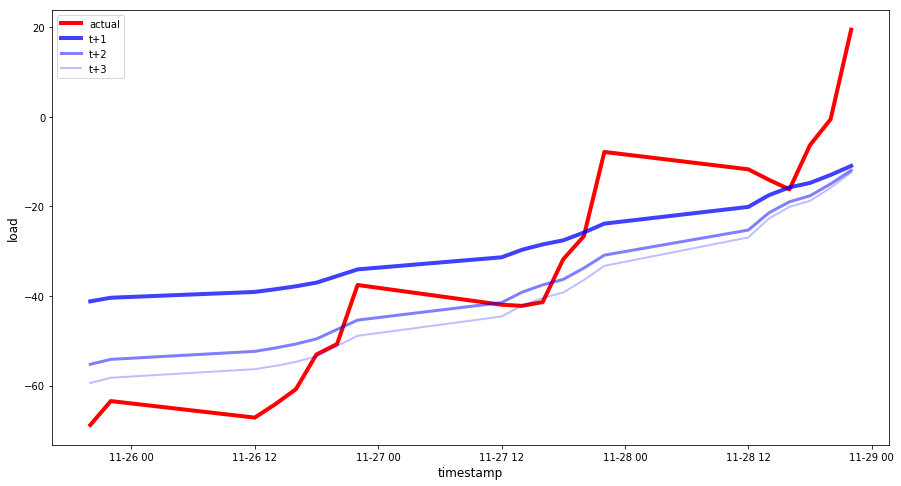

In [38]:
plot_df = eval_df[(eval_df.h=='t+1')][['timestamp', 'actual']]
for t in range(1, HORIZON+1):
    plot_df['t+'+str(t)] = eval_df[ (eval_df.h=='t+'+str(t))]['prediction'].values

fig = plt.figure(figsize=(15, 8))
ax = plt.plot(plot_df['timestamp'], plot_df['actual'], color='red', linewidth=4.0)
ax = fig.add_subplot(111)
ax.plot(plot_df['timestamp'], plot_df['t+1'], color='blue', linewidth=4.0, alpha=0.75)
ax.plot(plot_df['timestamp'], plot_df['t+2'], color='blue', linewidth=3.0, alpha=0.5)
ax.plot(plot_df['timestamp'], plot_df['t+3'], color='blue', linewidth=2.0, alpha=0.25)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
ax.legend(loc='best')
plt.show()

# take input here

In [39]:
a = df.iloc[156:162  , :]
a

,Crs
Epoch_Time_of_Clock,
2017-11-28 22:00:00,-0.56250000000000000000
2017-11-29 12:00:00,19.43750000000000000000
2017-11-29 14:00:00,16.78125000000000000000
2017-11-29 16:00:00,14.40625000000000000000
2017-11-29 18:00:00,10.03125000000000000000
2017-11-29 20:00:00,18.53125000000000000000


In [40]:
new_df = pd.DataFrame()

In [41]:
columns = [var_name] 

In [42]:
for key , value in enumerate(columns):
    new_df[value] = a[value]

In [43]:
new_df = new_df.dropna( how = 'any')

In [44]:
new_df

,Crs
Epoch_Time_of_Clock,
2017-11-28 22:00:00,-0.56250000000000000000
2017-11-29 12:00:00,19.43750000000000000000
2017-11-29 14:00:00,16.78125000000000000000
2017-11-29 16:00:00,14.40625000000000000000
2017-11-29 18:00:00,10.03125000000000000000
2017-11-29 20:00:00,18.53125000000000000000


In [45]:
# creating index for output
import datetime
date = new_df.index.date[0]
date + datetime.timedelta(1)

datetime.date(2017, 11, 29)

In [46]:
import datetime
date = new_df.index + datetime.timedelta(days =1)

In [47]:
date

DatetimeIndex(['2017-11-29 22:00:00', '2017-11-30 12:00:00',
               '2017-11-30 14:00:00', '2017-11-30 16:00:00',
               '2017-11-30 18:00:00', '2017-11-30 20:00:00'],
              dtype='datetime64[ns]', name='Epoch_Time_of_Clock', freq=None)

In [48]:
new_df.index= date

In [49]:
new_df.columns

Index(['Crs'], dtype='object')

In [50]:
print(new_df)
print(new_df.columns)

                                        Crs
Epoch_Time_of_Clock                        
2017-11-29 22:00:00 -0.56250000000000000000
2017-11-30 12:00:00 19.43750000000000000000
2017-11-30 14:00:00 16.78125000000000000000
2017-11-30 16:00:00 14.40625000000000000000
2017-11-30 18:00:00 10.03125000000000000000
2017-11-30 20:00:00 18.53125000000000000000
Index(['Crs'], dtype='object')


In [51]:
freq = None
idx_tuples = []
drop_incomplete  = True
new_df[[var_name]] = X_scaler.transform(new_df)
new_new_df = new_df.copy()
tensor_structure={'X':(range(-T+1, 1), [var_name])}
for name, structure in tensor_structure.items():
        rng = structure[0]
        dataset_cols = structure[1]
        for col in dataset_cols:
        # do not shift non-sequential 'static' features
            if rng is None:
                new_df['context_'+col] = new_df[col]
                idx_tuples.append((name, col, 'static'))
            else:
                for t in rng:
                    sign = '+' if t > 0 else ''
                    shift = str(t) if t != 0 else ''
                    period = 't'+sign+shift
                    shifted_col = name+'_'+col+'_'+ period
                    new_new_df[shifted_col] = new_new_df[col].shift(t*-1, freq=freq)
                    idx_tuples.append((name, col, period))
        new_new_df = new_new_df.drop(new_df.columns, axis=1)
        idx = pd.MultiIndex.from_tuples(idx_tuples, names=['tensor', 'feature', 'time step'])
        print(new_df.head())
        new_new_df.columns = idx
        if drop_incomplete:
            new_new_df = new_new_df.dropna(how='any')
            
inputs = {}           
for name, structure in tensor_structure.items():
    rng = structure[0]
    cols = structure[1]
    tensor = new_new_df[name][cols].as_matrix()
    if rng is None:
        tensor = tensor.reshape(tensor.shape[0], len(cols))
    else:
        tensor = tensor.reshape(tensor.shape[0], len(cols), len(rng))
        tensor = np.transpose(tensor, axes=[0, 2, 1])
    inputs[name] = tensor

                                       Crs
Epoch_Time_of_Clock                       
2017-11-29 22:00:00 0.17508290120173736204
2017-11-30 12:00:00 0.58904370475458978085
2017-11-30 14:00:00 0.53406453553272659196
2017-11-30 16:00:00 0.48490669011082537798
2017-11-30 18:00:00 0.39435276433363891657


In [52]:
print(new_new_df)
print(inputs['X'])

tensor                                   X                         \
feature                                Crs                          
time step                              t-5                    t-4   
Epoch_Time_of_Clock                                                 
2017-11-30 20:00:00 0.17508290120173736204 0.58904370475458978085   

tensor                                                             \
feature                                                             
time step                              t-3                    t-2   
Epoch_Time_of_Clock                                                 
2017-11-30 20:00:00 0.53406453553272659196 0.48490669011082537798   

tensor                                                             
feature                                                            
time step                              t-1                      t  
Epoch_Time_of_Clock                                                
2017-11-30 20:00:00 0.39435276433363

In [53]:
predictions = model.predict(inputs['X'])

In [54]:
predictions

array([[0.1835639 , 0.27831218, 0.3118255 , 0.30805165, 0.28424498,
        0.25203753]], dtype=float32)

In [55]:
print(predictions.shape)


(1, 6)


In [56]:
results = predictions[-1, :]

In [57]:
results

array([0.1835639 , 0.27831218, 0.3118255 , 0.30805165, 0.28424498,
       0.25203753], dtype=float32)

In [58]:
res_df = pd.DataFrame(results , columns = [var_name])
res_df

,Crs
0,0.18356390297412872314
1,0.27831217646598815918
2,0.31182551383972167969
3,0.30805164575576782227
4,0.28424498438835144043
5,0.25203752517700195312


In [59]:
res_df.index = date
res_df

,Crs
Epoch_Time_of_Clock,
2017-11-29 22:00:00,0.18356390297412872314
2017-11-30 12:00:00,0.27831217646598815918
2017-11-30 14:00:00,0.31182551383972167969
2017-11-30 16:00:00,0.30805164575576782227
2017-11-30 18:00:00,0.28424498438835144043
2017-11-30 20:00:00,0.25203752517700195312


In [60]:
res_df[var_name] = y_scalar.inverse_transform(res_df[[var_name]])    

# final generated output 

In [61]:
# final generated ouput
res_df

,Crs
Epoch_Time_of_Clock,
2017-11-29 22:00:00,-0.15275110304355621338
2017-11-30 12:00:00,4.42489337921142578125
2017-11-30 14:00:00,6.04404926300048828125
2017-11-30 16:00:00,5.86171913146972656250
2017-11-30 18:00:00,4.71152973175048828125
2017-11-30 20:00:00,3.15546679496765136719


In [62]:
res_df.to_csv('SA1_Crs.csv')